In [134]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import dill

# Load environments
import gym
import gym_maze


# To avoid Type3 fonts in generated pdf file
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# EXPERIMENT CONFIGURATION

In [135]:
MAZE = "Maze5-v0" 

# The number of samples to be replayed druing ER phase
ER_SAMPLES_NUMBER_LIST = [1,2,3,4,5,6,7,8,9,10]

EXPERIMENT_NAME = "10"
DATA_BASE_PATH = "" # CURRENT LOCATION
DATA_PATH = os.path.join(DATA_BASE_PATH, 'MAZE', EXPERIMENT_NAME, MAZE)


## DATA

In [136]:
def _load_data(path, file_name):
    full_dir_path = os.path.join(DATA_PATH, path)
    full_file_path = os.path.join(full_dir_path, f'{file_name}.dill')

    return dill.load(open(full_file_path, 'rb'))

def _load_agent_data(agent_name, path, file_name):
    path = os.path.join(agent_name, path)
    return _load_data(path, file_name)

def _load_metrics(agent_name, path, metrics_name):
    return _load_agent_data(agent_name, path, f'metrics_{metrics_name}')

def _load_explore_metrics(agent_name, path):
    return _load_metrics(agent_name, path, 'EXPLORE')

def _load_exploit_metrics(agent_name, path):
    return _load_metrics(agent_name, path, 'EXPLOIT')

def _load_population(agent_name, path):
    return _load_agent_data(agent_name, path, 'population')

def _load_environment(agent, path):
    return _load_agent_data(agent, path, 'env')
    
def _load_experiment_data(agent_name, path):
    explore_metrics = _load_explore_metrics(agent_name, path)
    exploit_metrics = _load_exploit_metrics(agent_name, path)
    population = _load_population(agent_name, path)
    env = _load_environment(agent_name, path)

    return (explore_metrics, exploit_metrics, population, env)

def load_acs2_experiment_data():
    return _load_experiment_data('ACS2', '')

def _load_acs2er_experiment_data(er_samples_number):
    return _load_experiment_data('ACS2ER', f'm_{er_samples_number}')

def load_acs2er_experiments_data():
    return list(map(lambda m: (m, _load_acs2er_experiment_data(m)), ER_SAMPLES_NUMBER_LIST))

## Data Analysis

In [137]:
def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['trial']
        row['steps'] = row['steps_in_trial']
        row['numerosity'] = row['numerosity']
        row['reliable'] = row['reliable']
        row['knowledge'] = row['knowledge']
        return row
    
    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)
    
    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'
    
    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)
    
    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial']+len(explore_df), axis=1)
    
    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.set_index('trial', inplace=True)
    
    return df

def find_best_classifier(population, situation):
    match_set = population.form_match_set(situation)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]
    
    if (len(anticipated_change_cls) > 0):
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)
    
    return None

def build_fitness_matrix(env, population):
    original = env.env.maze.matrix
    fitness = original.copy()
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index)
            best_cl = find_best_classifier(population, perception)
            if best_cl:
                fitness[index] = best_cl.fitness
            else:
                fitness[index] = -1
        
        # Wall - fitness = 0
        if x == 1:
            fitness[index] = 0
        
        # Reward - inf fitness
        if x == 9:
            fitness[index] = fitness.max () + 500
        
    return fitness
    
def build_action_matrix(env, population):
    ACTION_LOOKUP = { 
        0: u'↑', 1: u'↗', 2: u'→', 3: u'↘',
        4: u'↓', 5: u'↙', 6: u'←', 7: u'↖'
    }
    
    original = env.env.maze.matrix
    action = original.copy().astype(str)
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index)
            best_cl = find_best_classifier(population, perception)
            if best_cl:
                action[index] = ACTION_LOOKUP[best_cl.action]
            else:
                action[index] = '?'
        
        # Wall - fitness = 0
        if x == 1:
            action[index] = '\#'
        
        # Reward - inf fitness
        if x == 9:
            action[index] = 'R'
        
    return action


# Plot constants
TITLE_TEXT_SIZE=24
AXIS_TEXT_SIZE=18
LEGEND_TEXT_SIZE=16


def plot_policy(env, population, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_aspect("equal")
    
    # Handy variables
    max_x, max_y = env.env.maze.matrix.shape
    
    fitness_matrix = build_fitness_matrix(env, population)
    action_matrix = build_action_matrix(env, population)
    
    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='nearest', cmap='Reds', aspect='auto', extent=[0, max_x, max_y, 0])
    
    
    # Add labels to each cell
    for (y,x), val in np.ndenumerate(action_matrix):
        plt.text(x+0.4, y+0.5, "${}$".format(val))
    
    ax.set_title("Policy", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel('x', fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel('y', fontsize=AXIS_TEXT_SIZE)

    ax.set_xlim(0, max_x)
    ax.set_ylim(max_y, 0)
    
    ax.set_xticks(range(0, max_x))
    ax.set_yticks(range(0, max_y))
    
    ax.grid(True)

def plot_knowledge(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
        
    explore_df['knowledge'].plot(ax=ax, c='blue')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
        
    ax.set_title("Achieved knowledge", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Knowledge [%]", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylim([0, 105])


def plot_steps(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    explore_df['steps'].plot(ax=ax, c='blue', linewidth=.5)
    exploit_df['steps'].plot(ax=ax, c='red', linewidth=0.5)
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Steps", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Steps", fontsize=AXIS_TEXT_SIZE)


def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')    
    
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Classifiers", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Classifiers", fontsize=AXIS_TEXT_SIZE)
    ax.legend(fontsize=LEGEND_TEXT_SIZE)


def plot_performance(population, maze, metrics_df, agent_name):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle(f'{agent_name} Performance in {MAZE} environment', fontsize=32)
    
    ax1 = plt.subplot(221)
    plot_policy(maze, population, ax1)
    
    ax2 = plt.subplot(222)
    plot_knowledge(metrics_df, ax2)
    
    ax3 = plt.subplot(223)
    plot_classifiers(metrics_df, ax3)
    
    ax4 = plt.subplot(224)
    plot_steps(metrics_df, ax4)
    
    plt.subplots_adjust(top=0.86, wspace=0.3, hspace=0.3)

<>:87: DeprecationWarning: invalid escape sequence \#


In [138]:
def get_acs2_experiment_data():
  explore_metrics, exploit_metrics, population, env = load_acs2_experiment_data()

  return (parse_metrics_to_df(explore_metrics, exploit_metrics), population, env)

def get_acs2er_experiments_data():
  return list(map(lambda ed: (ed[0], (parse_metrics_to_df(ed[1][0], ed[1][1]), ed[1][2], ed[1][3])), load_acs2er_experiments_data()))

acs2_data = get_acs2_experiment_data()
acs2er_data = get_acs2er_experiments_data()

In [139]:
KNOWLEDGE_ATTRIBUTE = 'knowledge'
NUMEROSITY_ATTRIBUTE = 'numerosity'
RELIABLE_ATTRIBUTE = 'reliable'
STEPS_ATTRIBUTE = 'steps'

plt.rcParams['figure.figsize'] = [13, 10]

def get_explore_metrics(metrics):
    return metrics.query("phase == 'explore'")

def get_exploit_metrics(metrics):
    return metrics.query("phase == 'exploit'")

def plot_attribute(metrics, attribute_name: str, label: str, explore_color: str, exploit_color: str, width: float = 1.5):
    explore = get_explore_metrics(metrics)
    exploit = get_exploit_metrics(metrics)

    x_axis_explore = range(1, len(explore) + 1)
    x_axis_exploit = range(len(explore) + 1, len(explore) + len(exploit) + 1)

    plt.plot(x_axis_explore, explore[attribute_name], c=explore_color, label=label, linewidth=width)
    plt.plot(x_axis_exploit, exploit[attribute_name], c=exploit_color, linewidth=width)


def plot_multiple_knowledge(metrics_list, title, width: float = 1.5):
    plt.close()
    plt.title(f"KNOWLEDGE - {title}")

    for (label, explore_color, exploit_color), metric in metrics_list:
        plot_attribute(metric, KNOWLEDGE_ATTRIBUTE, label, explore_color, exploit_color, width)

    plt.axvline(x=len(get_explore_metrics(metrics_list[0][1])), c='black', linestyle='dashed')

    plt.legend()
    plt.xlabel(f"Trial")
    plt.ylabel("Knowledge [%]")
    plt.show()

def plot_multiple_classifiers(metrics_list, title, width: float = 1.5):
    plt.close()
    plt.title(f"CLASSIFIERS NUMEROSITY (num) and RELIABLE (rel) - {title}")
    
    for (label, num_color, rel_color), metric in metrics_list:
        plot_attribute(metric, NUMEROSITY_ATTRIBUTE, f'{label}-num', num_color, num_color, width)
        plot_attribute(metric, RELIABLE_ATTRIBUTE, f'{label}-rel', rel_color, rel_color, width)

    plt.axvline(x=len(get_explore_metrics(metrics_list[0][1])), c='black', linestyle='dashed')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(f"Trial")
    plt.ylabel("Classifiers")
    plt.show()

def print_average_exploit_steps(metrics, label: str):
    exploit = get_exploit_metrics(metrics)

    steps_avg = np.mean(np.array(exploit[STEPS_ATTRIBUTE]))

    print(f"Steps {label}: {steps_avg}")

def print_knowledge_completed(metrics, label: str):
    explore = get_explore_metrics(metrics)
    knowledge_completed = explore.query(f"{KNOWLEDGE_ATTRIBUTE} == 100")

    if(len(knowledge_completed) == 0):
        print(f"Knowledge for {label} NOT completed")

        return

    print(f"Knowledge for {label} completed at trial: {knowledge_completed.index[0]}")

In [140]:

def plot_acs2_result():
  metrics, population, env = acs2_data
  plot_performance(population, env, metrics, 'ACS2')

def plot_acs2er_result(er_samples_number):
  m, (acs2_metrics, acs2_population, acs2_env) = list(filter(lambda ed: ed[0] == er_samples_number, acs2er_data))[0]
  plot_performance(acs2_population, acs2_env, acs2_metrics, f'ACS2ER - {m}-samples')

def plot_acs2er_results():
  for m in ER_SAMPLES_NUMBER_LIST:
    plot_acs2er_result(m)

In [141]:
def plot_acs2er_knowledge():
    # COLORS = ['r', 'g', 'b']
    COLORS = ['#FF9634', '#FFEE15', '#A7FF15', '#29FF2F', '#44FBD1', '#49BDFA', '#316EF9', '#965FFF', '#FE4DFE', '#FF63A5']

    def get_metric_record(index, data):
        m, (metric, _, _) = data

        return (f'm-{m}', COLORS[index], COLORS[index]), metric

    metrics_list = list(map(lambda d: get_metric_record(d[0], d[1]), enumerate(acs2er_data)))

    plot_multiple_knowledge(metrics_list, 'ACS2ER')

def plot_acs2er_classifiers():
    # COLORS_NUM = ['r', 'g', 'b']
    COLORS_NUM = ['#FF9634', '#FFEE15', '#A7FF15', '#29FF2F', '#44FBD1', '#49BDFA', '#316EF9', '#965FFF', '#FE4DFE', '#FF63A5']

    # COLORS_REL = ['#FFA4A4', '#A4FFB3', '#A4FEFF']
    COLORS_REL = ['#FFCD9F', '#FFF89F', '#D6FF91', '#BEFFBF', '#C2FFF1', '#C0EAFF', '#C2D5FF', '#DAC7FF', '#FDAAFD', '#F6C5DA']

    def get_metric_record(index, data):
        m, (metric, _, _) = data

        return (f'm-{m}', COLORS_NUM[index], COLORS_REL[index]), metric

    metrics_list = list(map(lambda d: get_metric_record(d[0], d[1]), enumerate(acs2er_data)))

    plot_multiple_classifiers(metrics_list, 'ACS2ER')

def print_acs2er_exploit_steps():
    for m, (metric, _, _) in acs2er_data:
        print_average_exploit_steps(metric, f'M-{m}')

def print_acs2er_knowledge_completed():
    for m, (metric, _, _) in acs2er_data:
        print_knowledge_completed(metric, f'M-{m}')

def plot_acs2_acs2er_knowledge():
    # COLORS = ['r', 'g', 'b']
    COLORS = ['#FF9634', '#FFEE15', '#A7FF15', '#29FF2F', '#44FBD1', '#49BDFA', '#316EF9', '#965FFF', '#FE4DFE', '#FF63A5']
    acs2_metric, _, _ = acs2_data
    def get_metric_record(index, data):
        m, (metric, _, _) = data

        return (f'acs2er - m-{m}', COLORS[index], COLORS[index]), metric

    metrics_list = list(map(lambda d: get_metric_record(d[0], d[1]), enumerate(acs2er_data)))
    metrics_list.append((('acs2', '#FF2E2E', '#FF2E2E'), acs2_metric))

    plot_multiple_knowledge(metrics_list, 'ACS2ER vs ACS2')

def plot_acs2_acs2er_classifiers():
    # COLORS_NUM = ['r', 'g', 'b']
    COLORS_NUM = ['#FF9634', '#FFEE15', '#A7FF15', '#29FF2F', '#44FBD1', '#49BDFA', '#316EF9', '#965FFF', '#FE4DFE', '#FF63A5']

    # COLORS_REL = ['#FFA4A4', '#A4FFB3', '#A4FEFF']
    COLORS_REL = ['#FFCD9F', '#FFF89F', '#D6FF91', '#BEFFBF', '#C2FFF1', '#C0EAFF', '#C2D5FF', '#DAC7FF', '#FDAAFD', '#F6C5DA']

    acs2_metric, _, _ = acs2_data
    def get_metric_record(index, data):
        m, (metric, _, _) = data

        return (f'acs2er-{m}', COLORS_NUM[index], COLORS_REL[index]), metric

    metrics_list = list(map(lambda d: get_metric_record(d[0], d[1]), enumerate(acs2er_data)))
    metrics_list.append((('acs2', '#FF2E2E', '#FF9898'), acs2_metric))

    plot_multiple_classifiers(metrics_list, 'ACS2ER vs ACS2')

def print_acs2_acs2er_exploit_steps():
    acs2_metric, _, _ = acs2_data
    print_average_exploit_steps(acs2_metric, f'ACS2')
    for m, (metric, _, _) in acs2er_data:
        print_average_exploit_steps(metric, f'ACS2ER - M-{m}')

def print_acs2_acs2er_knowledge_completed():
    acs2_metric, _, _ = acs2_data
    print_knowledge_completed(acs2_metric, f'ACS2')
    for m, (metric, _, _) in acs2er_data:
        print_knowledge_completed(metric, f'ACS2ER - M-{m}')
    


# ACS2 Results

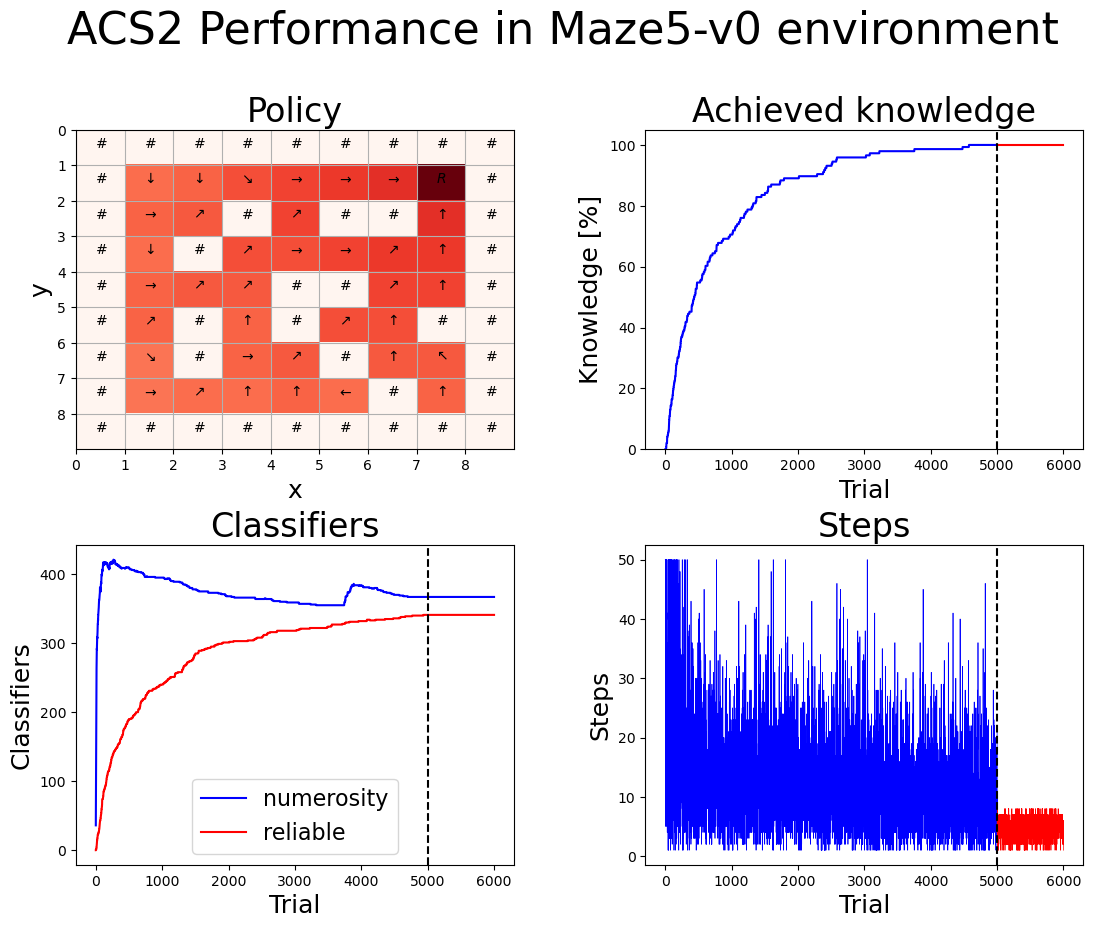

In [142]:
plot_acs2_result()

# ACS2ER Results

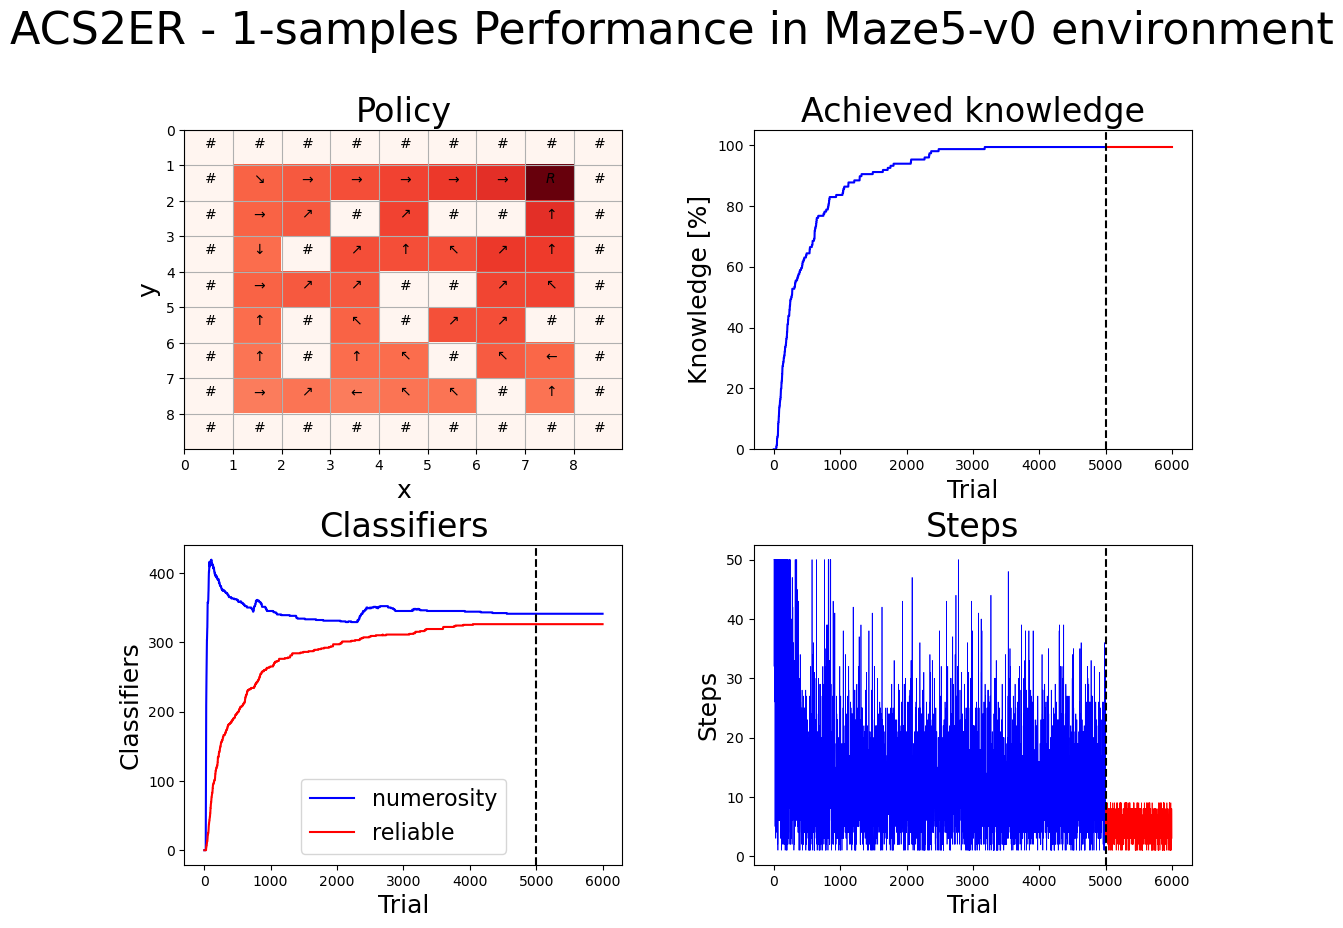

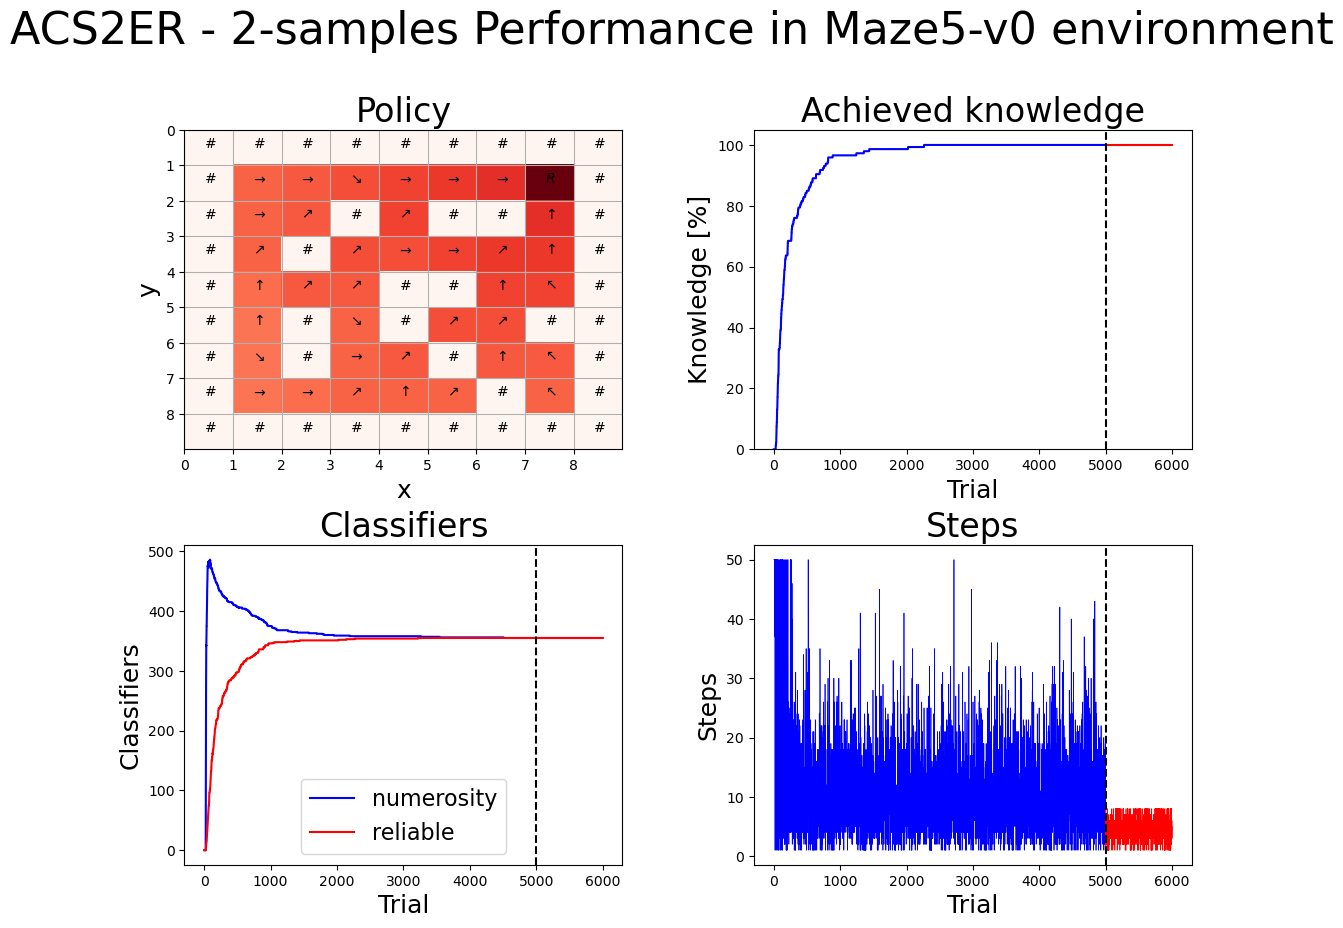

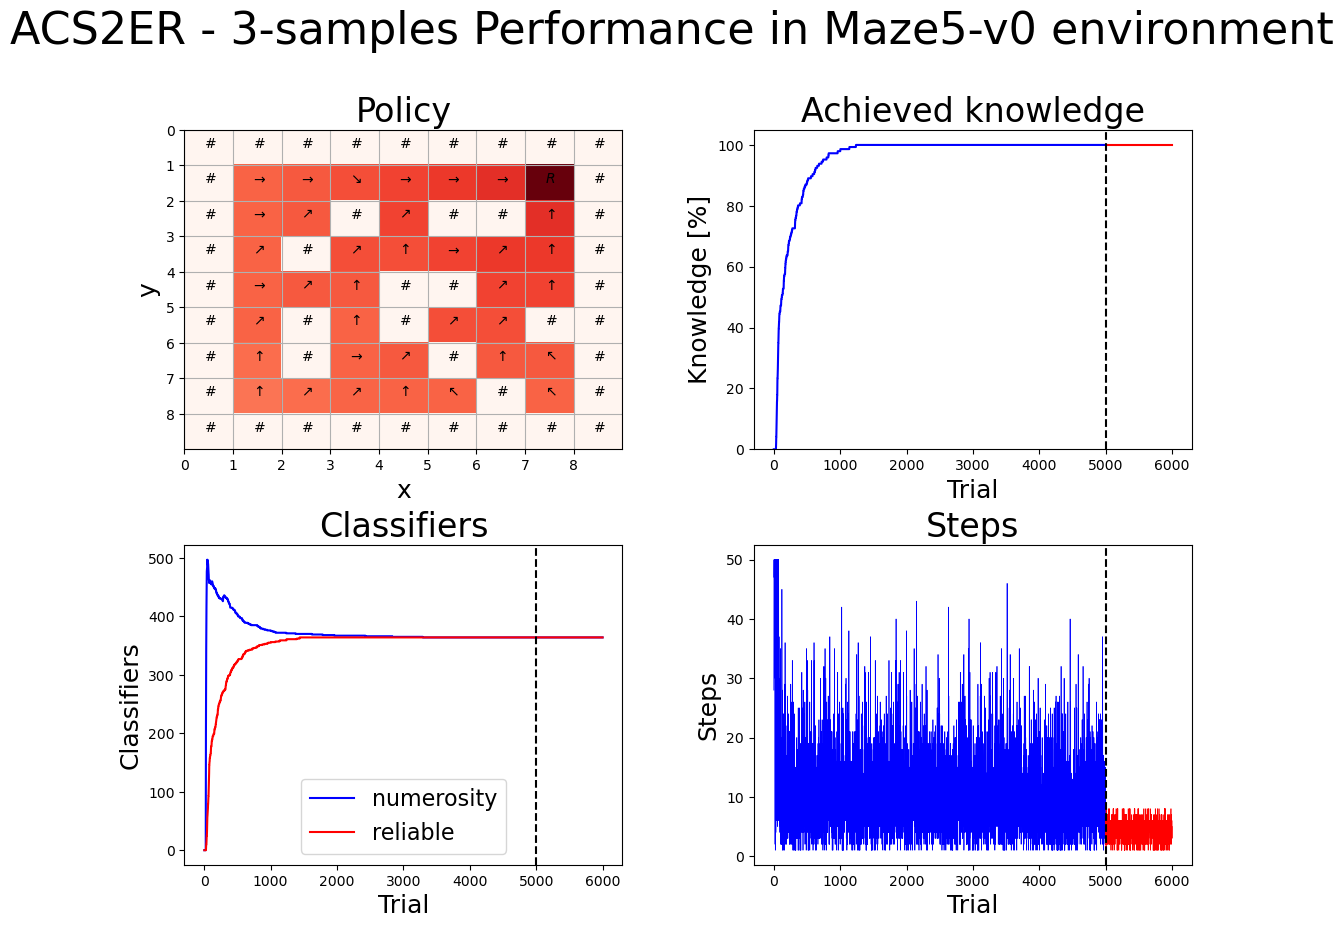

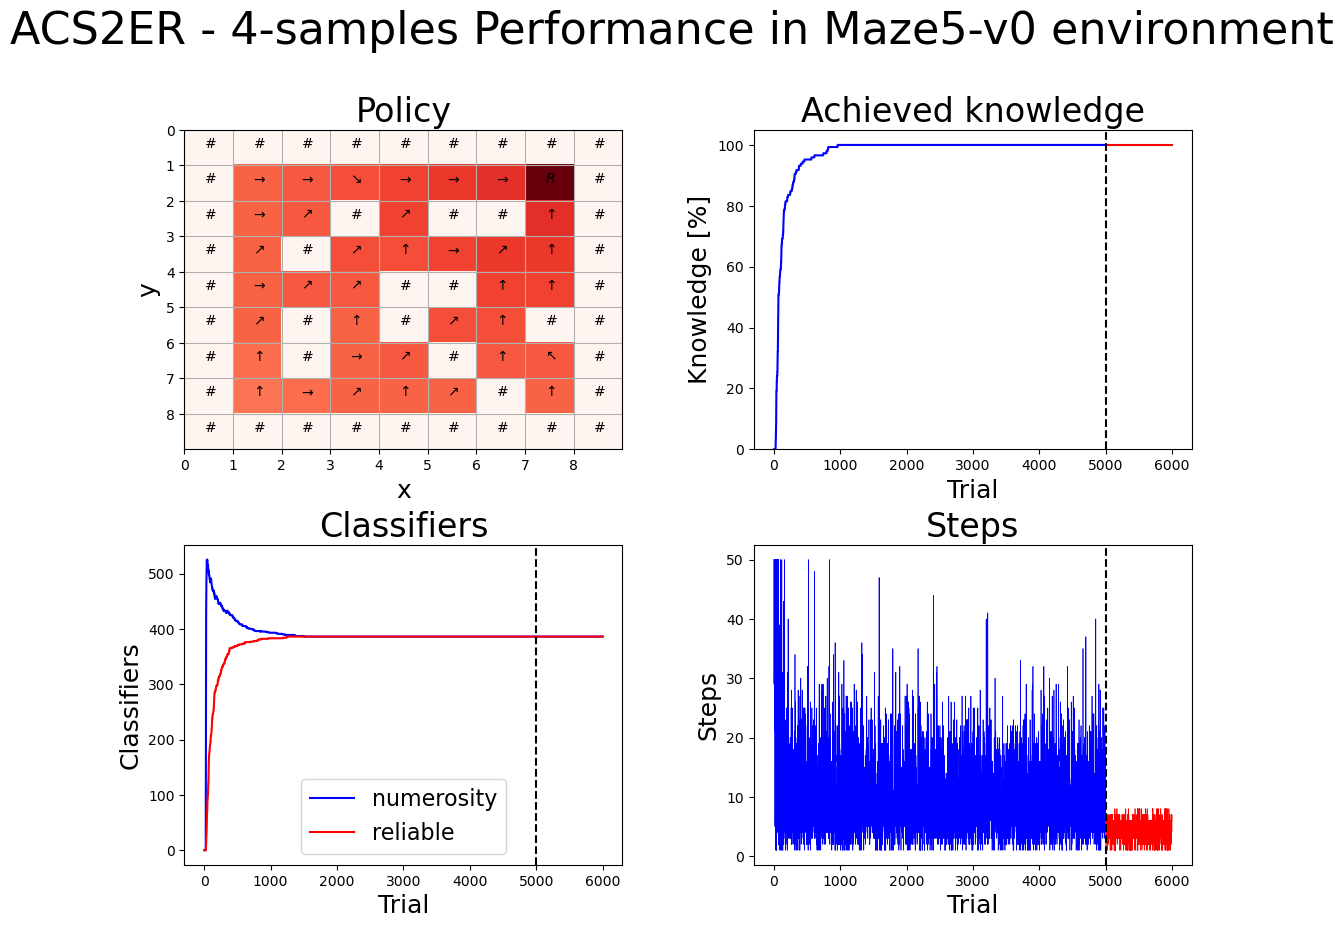

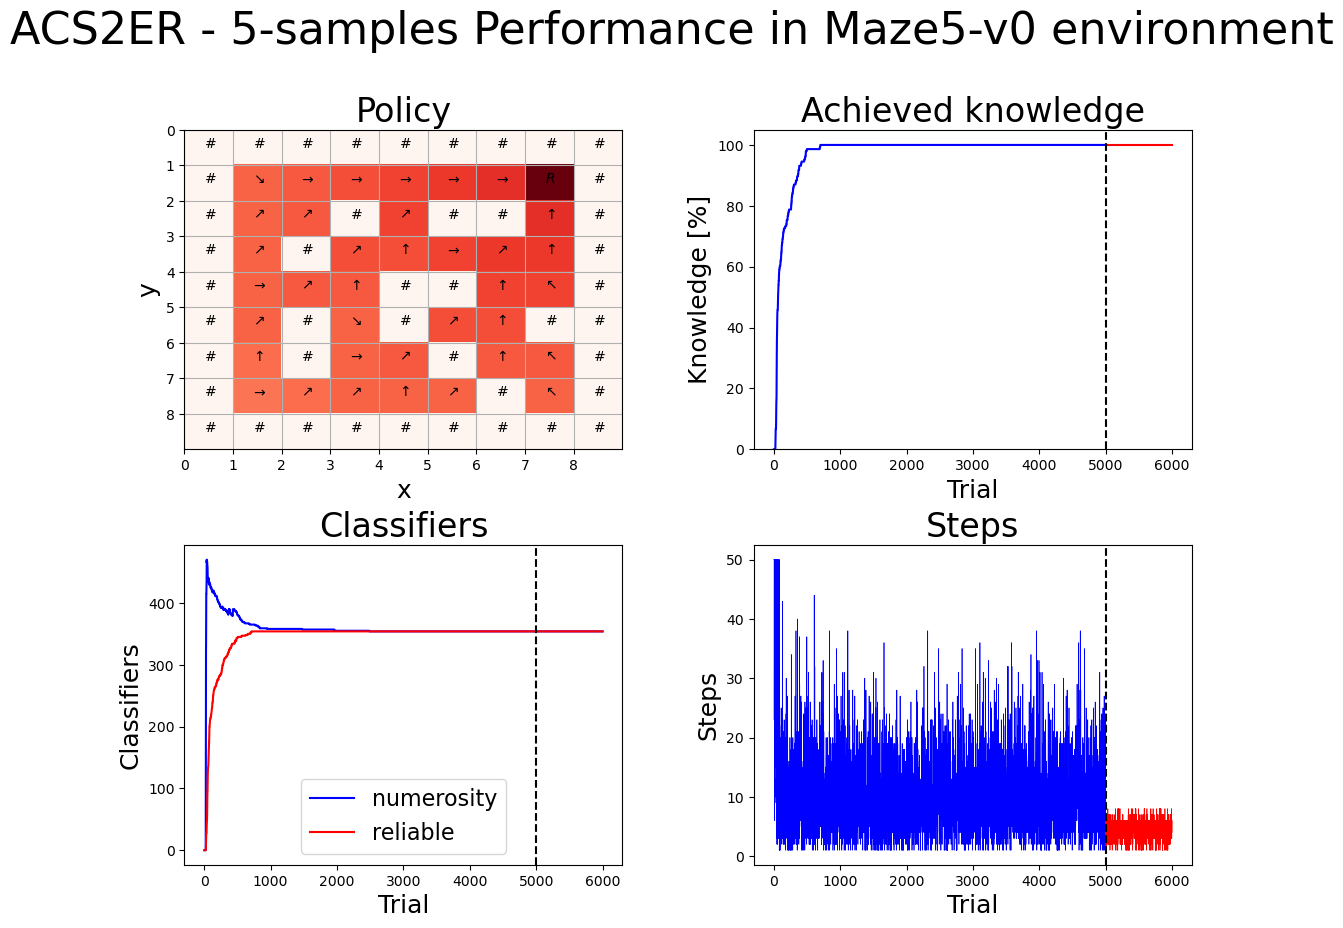

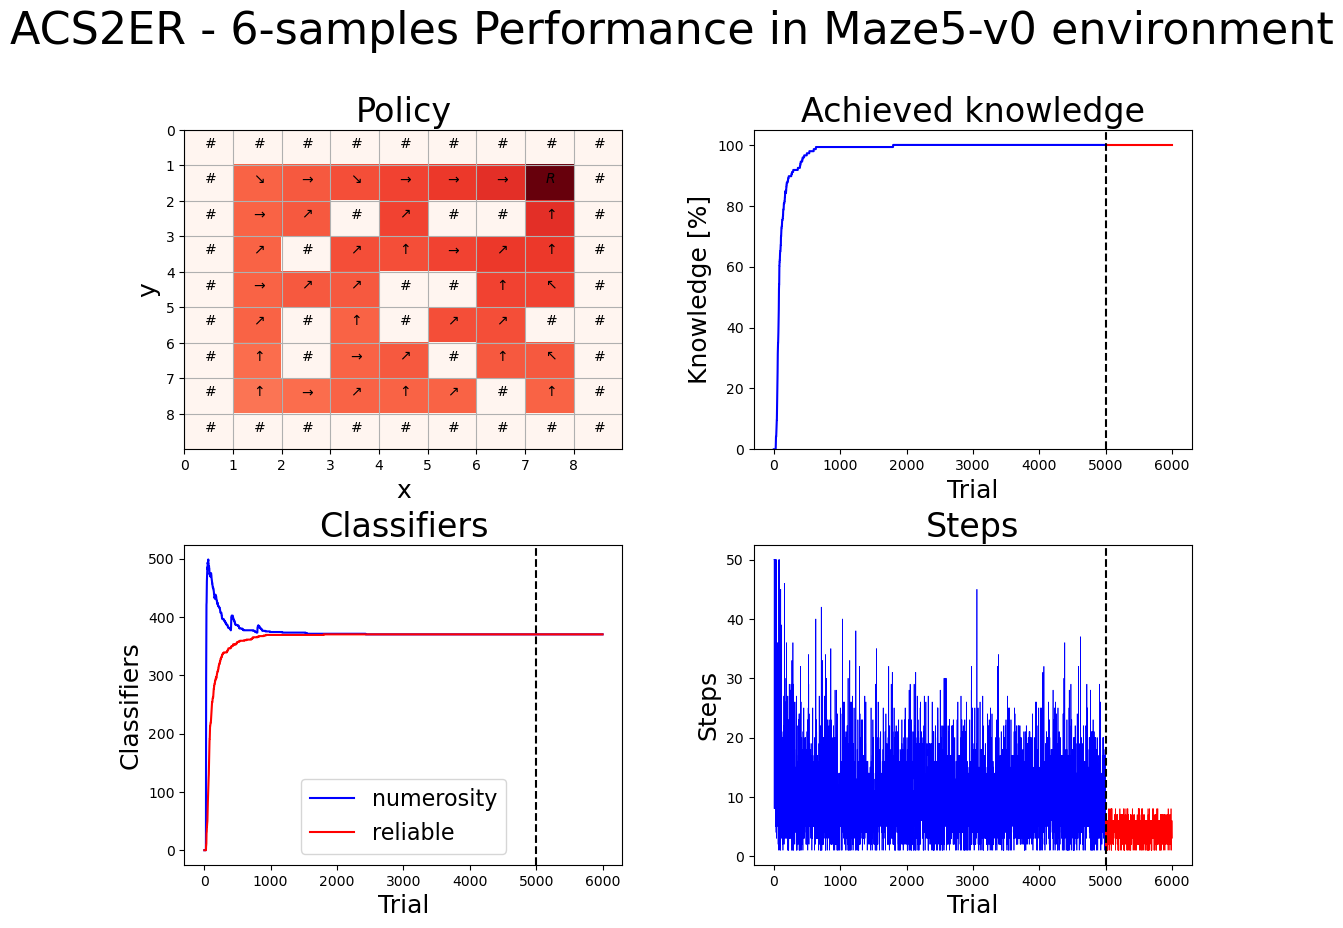

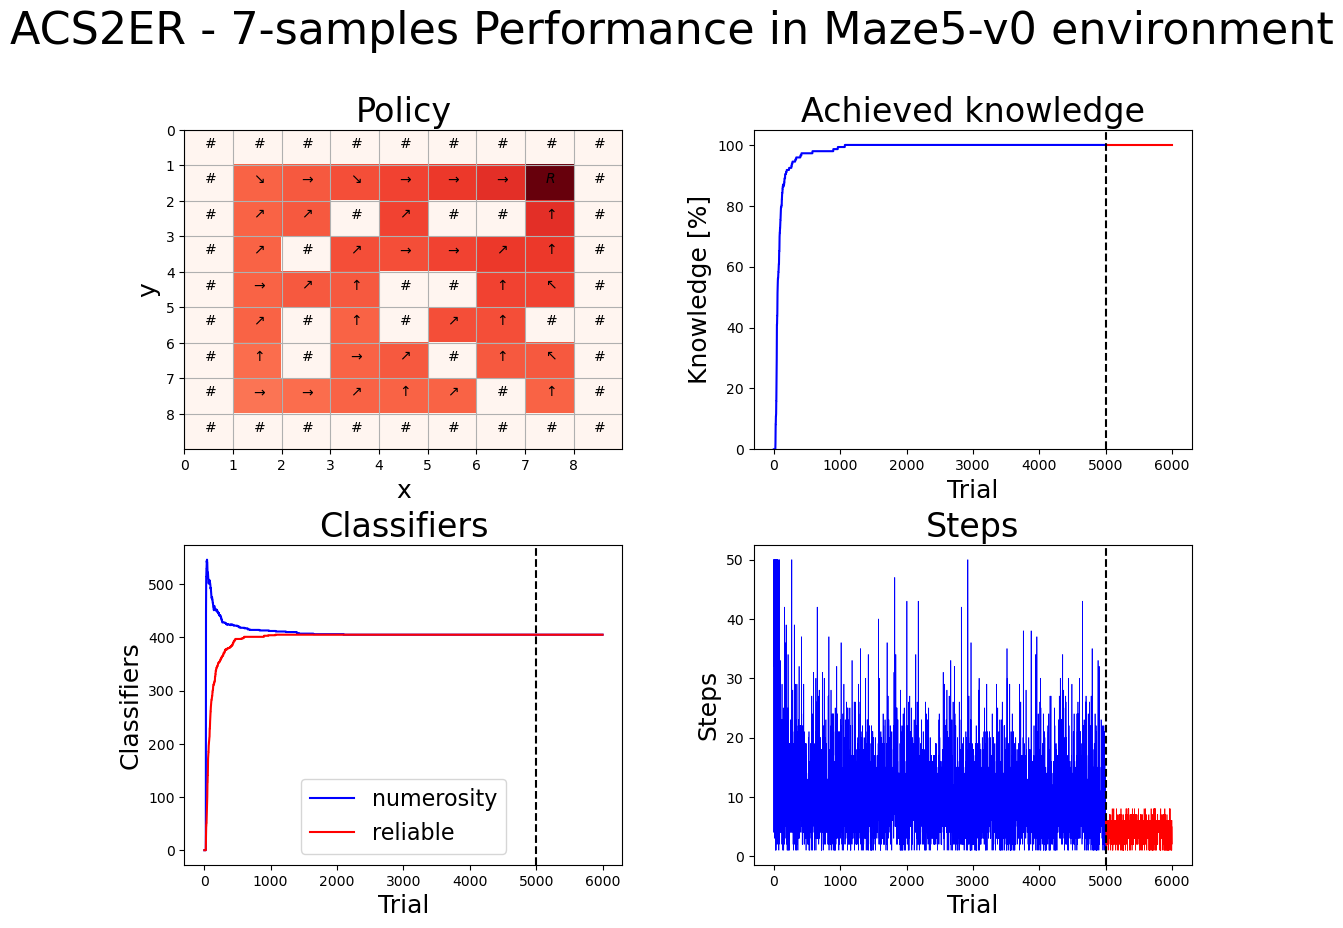

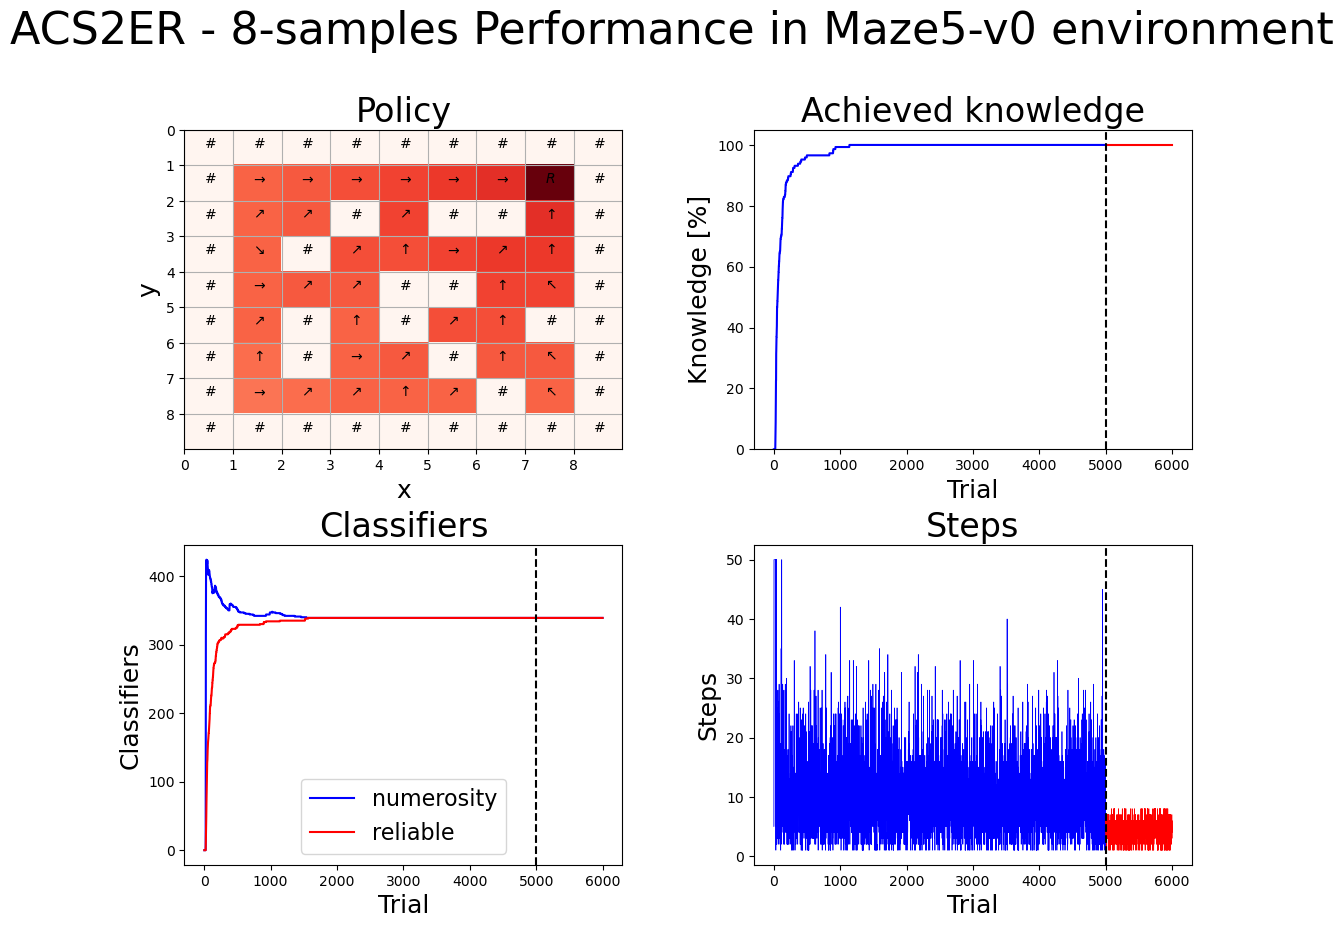

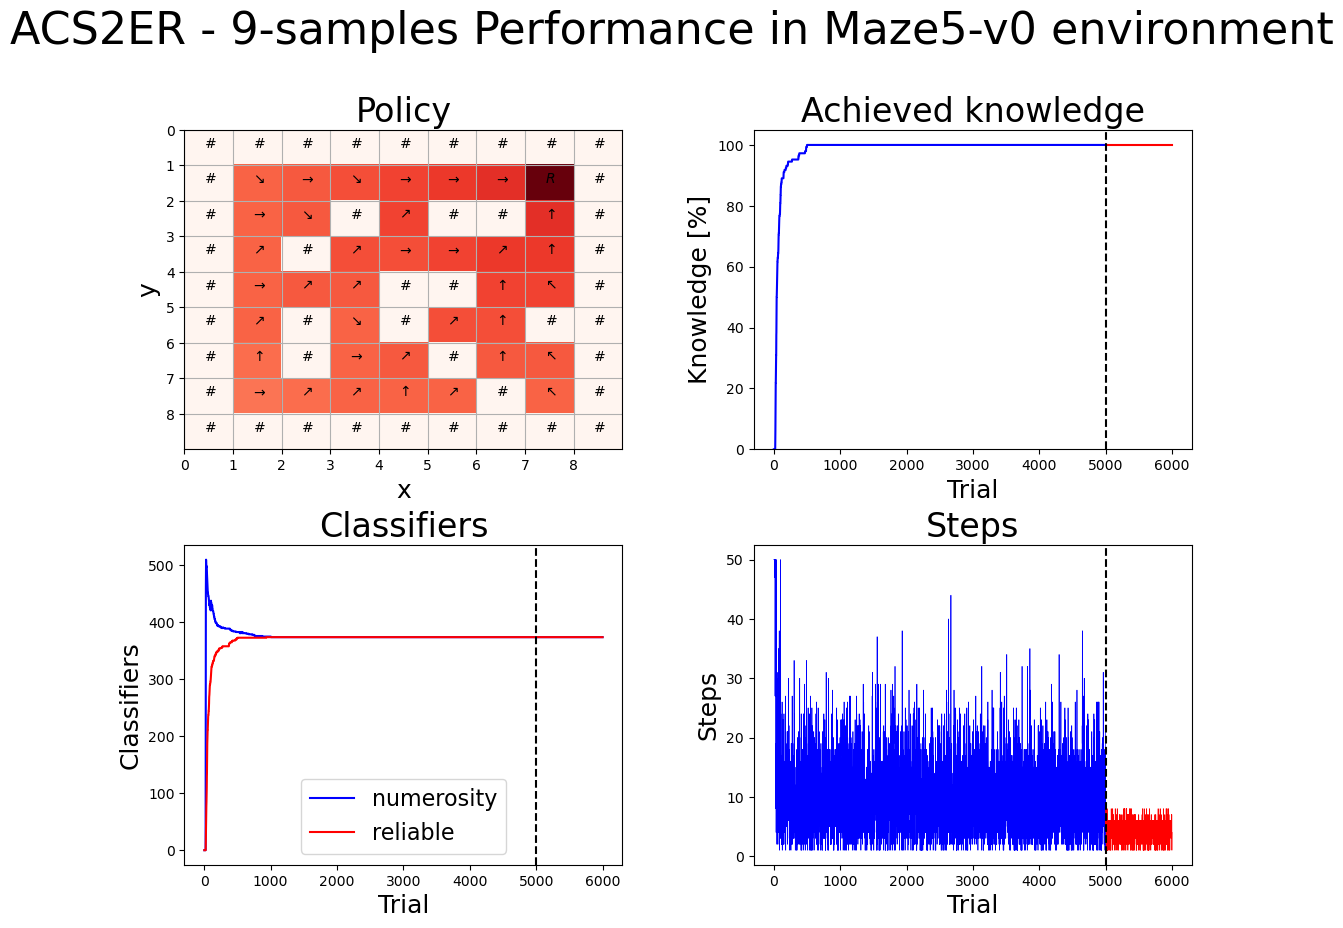

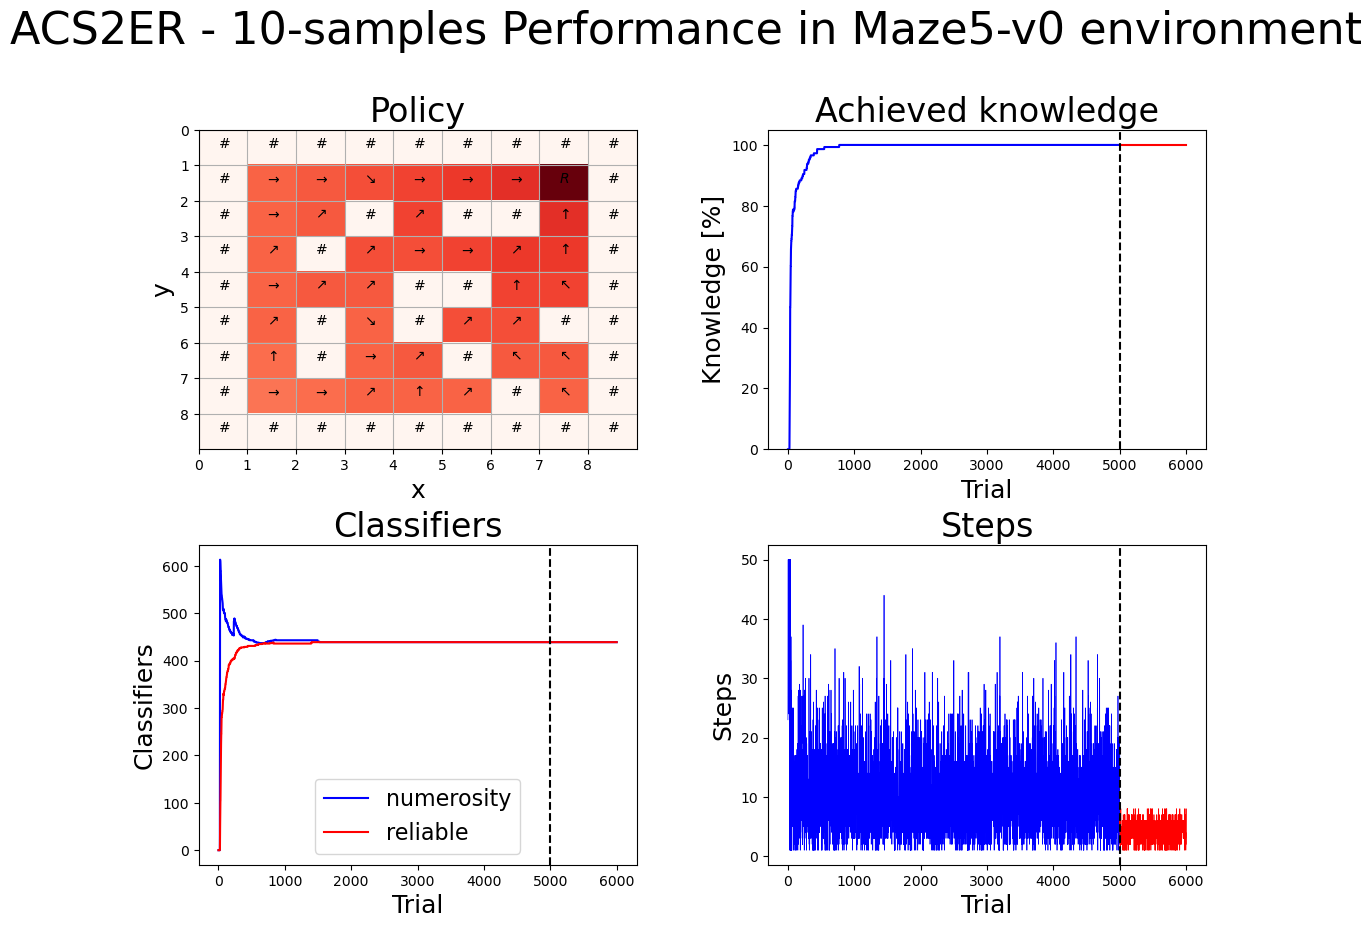

In [143]:
plot_acs2er_results()

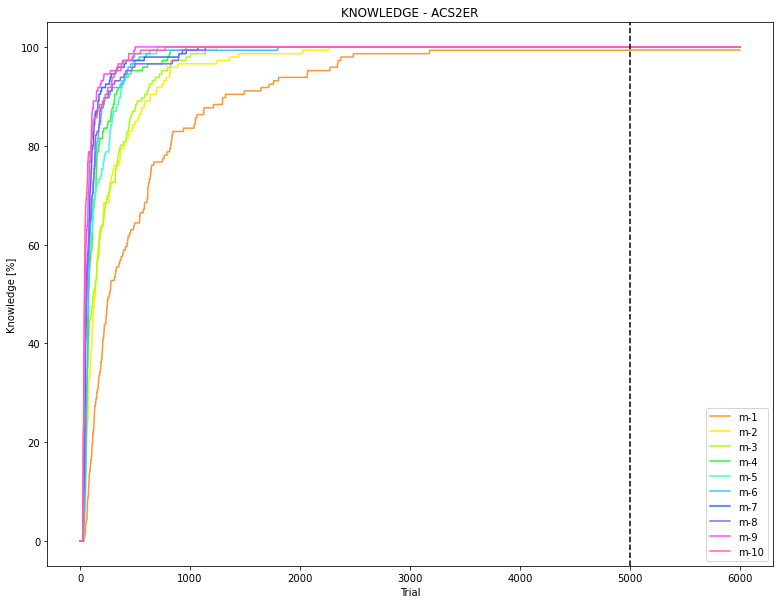

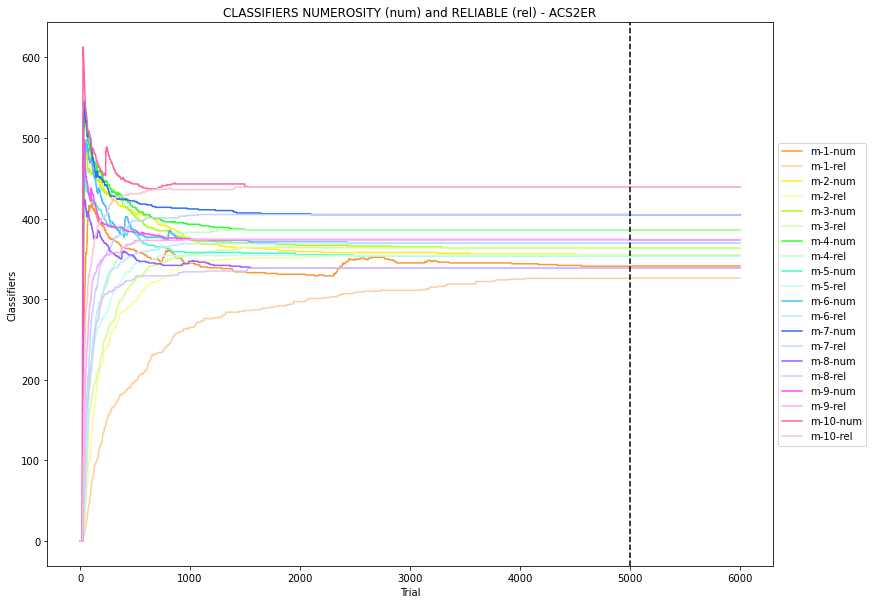

Steps M-1: 5.123
Steps M-2: 4.792
Steps M-3: 4.676
Steps M-4: 4.639
Steps M-5: 4.581
Steps M-6: 4.676
Steps M-7: 4.561
Steps M-8: 4.721
Steps M-9: 4.553
Steps M-10: 4.573
Knowledge for M-1 NOT completed
Knowledge for M-2 completed at trial: 2264
Knowledge for M-3 completed at trial: 1238
Knowledge for M-4 completed at trial: 962
Knowledge for M-5 completed at trial: 701
Knowledge for M-6 completed at trial: 1798
Knowledge for M-7 completed at trial: 1071
Knowledge for M-8 completed at trial: 1139
Knowledge for M-9 completed at trial: 500
Knowledge for M-10 completed at trial: 773


In [144]:
plot_acs2er_knowledge()
plot_acs2er_classifiers()
print_acs2er_exploit_steps()
print_acs2er_knowledge_completed()

## ACS2 vs ACS2ER

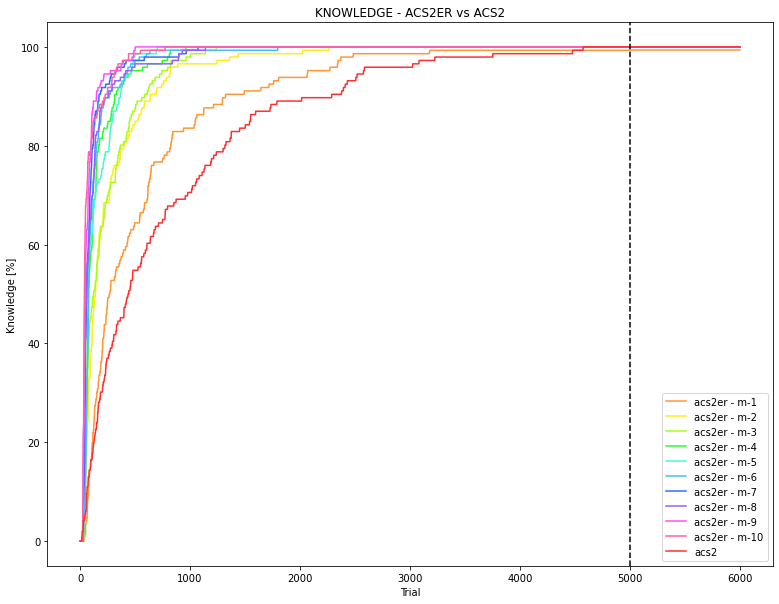

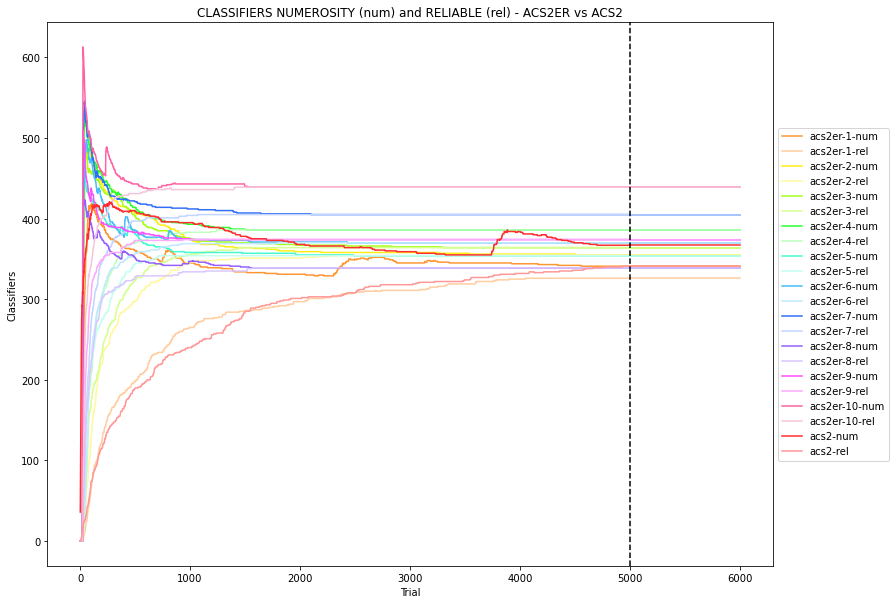

Steps ACS2: 4.818
Steps ACS2ER - M-1: 5.123
Steps ACS2ER - M-2: 4.792
Steps ACS2ER - M-3: 4.676
Steps ACS2ER - M-4: 4.639
Steps ACS2ER - M-5: 4.581
Steps ACS2ER - M-6: 4.676
Steps ACS2ER - M-7: 4.561
Steps ACS2ER - M-8: 4.721
Steps ACS2ER - M-9: 4.553
Steps ACS2ER - M-10: 4.573
Knowledge for ACS2 completed at trial: 4575
Knowledge for ACS2ER - M-1 NOT completed
Knowledge for ACS2ER - M-2 completed at trial: 2264
Knowledge for ACS2ER - M-3 completed at trial: 1238
Knowledge for ACS2ER - M-4 completed at trial: 962
Knowledge for ACS2ER - M-5 completed at trial: 701
Knowledge for ACS2ER - M-6 completed at trial: 1798
Knowledge for ACS2ER - M-7 completed at trial: 1071
Knowledge for ACS2ER - M-8 completed at trial: 1139
Knowledge for ACS2ER - M-9 completed at trial: 500
Knowledge for ACS2ER - M-10 completed at trial: 773


In [145]:
plot_acs2_acs2er_knowledge()
plot_acs2_acs2er_classifiers()
print_acs2_acs2er_exploit_steps()
print_acs2_acs2er_knowledge_completed()